<a href="https://colab.research.google.com/github/AshHydroCoder/LULC-Change/blob/main/LULC_Change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
pip install rasterio numpy matplotlib pandas

In [2]:
#Imports
import os
import zipfile
import rasterio
import numpy as np
import matplotlib.pyplot as plt
LULC_Folder = '/content/drive/MyDrive/Thesis/LULC Data Nepal'
OUT = '/content/drive/MyDrive/Thesis/LULC Data Nepal/Output/'

In [ ]:
#Extract tif files

for zip_file in os.listdir(LULC_Folder):
    if zip_file.endswith('.zip'):
        zip_path = os.path.join(LULC_Folder, zip_file)
        year = zip_file.split('_')[-1][:-4]
        with zipfile.ZipFile(zip_path, 'r') as zipf:
            for file in zipf.namelist():
              if file.endswith(".tif"):
                zipf.extract(file,OUT)
                extracted_file = os.path.join(OUT,file)
                print(extracted_file)
                new_file = os.path.join(OUT,f"land_cover_{year}.tif")
                os.rename(extracted_file, new_file)
                with rasterio.open(new_file) as src:
                  land_cover_data[year] = src.read(1)

/content/drive/MyDrive/Thesis/LULC Data Nepal/Output/nlcms_2000/data/lc2000.tif
/content/drive/MyDrive/Thesis/LULC Data Nepal/Output/nlcms_2001/data/lc2001.tif
/content/drive/MyDrive/Thesis/LULC Data Nepal/Output/nlcms_2002/data/lc2002.tif


KeyboardInterrupt: 

In [3]:
land_cover_data = {}
for tif in os.listdir(OUT):
  if tif.endswith(".tif"):
    year = tif.split("_")[-1][:-4]
    with rasterio.open(os.path.join(OUT,tif)) as src:
      land_cover_data[year] = src.read(1)
years = sorted(land_cover_data.keys())


In [65]:
#!pip install pdfplumber
import pdfplumber
pdf_path = '/content/drive/MyDrive/Thesis/LULC Data Nepal/Data Description.pdf'
land_cover_names = {}
with pdfplumber.open(pdf_path) as pdf:
    for page in pdf.pages:
        text = page.extract_text()
        lines = text.split('\n')
        for line in lines[2:]:
          parts = line.split()
          grid_value = int(parts[-1])
          class_name = ' '.join(parts[:-1])
          land_cover_names[grid_value] = class_name
print(land_cover_names)

{1: 'Waterbody', 2: 'Glacier', 3: 'Snow', 4: 'Forest', 5: 'Riverbed', 6: 'Built-up area', 7: 'Cropland', 8: 'Bare soil', 9: 'Bare rock', 10: 'Grassland', 11: 'Other wooded land'}


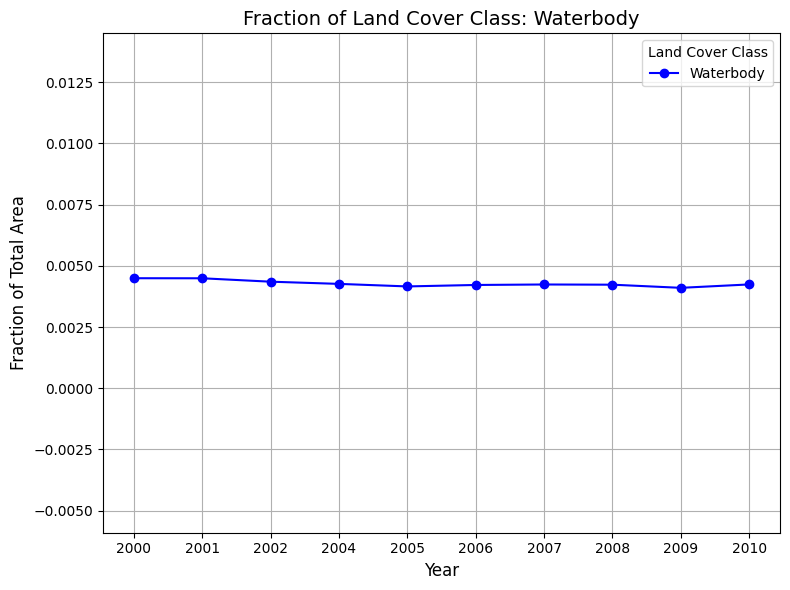

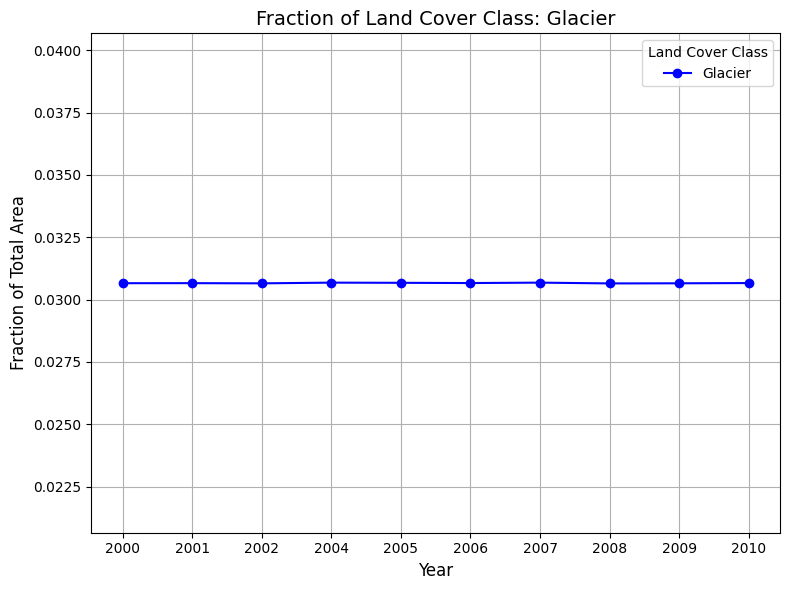

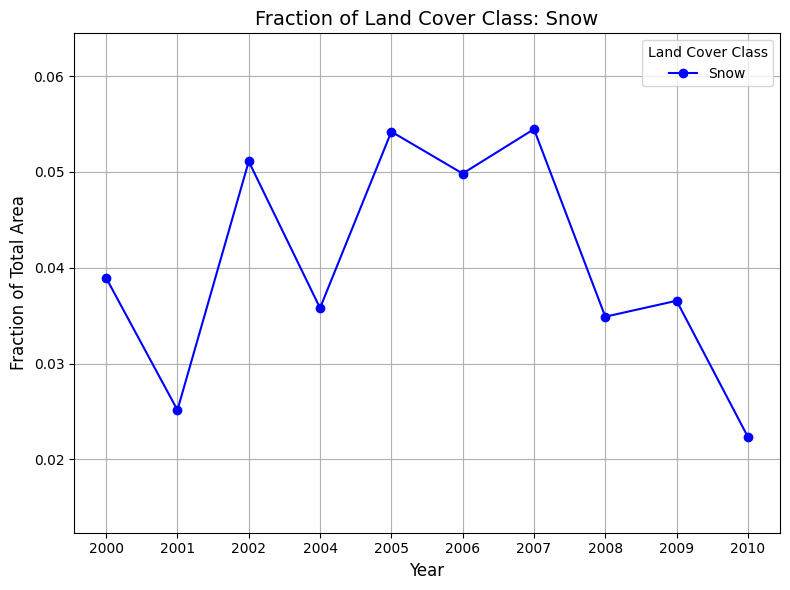

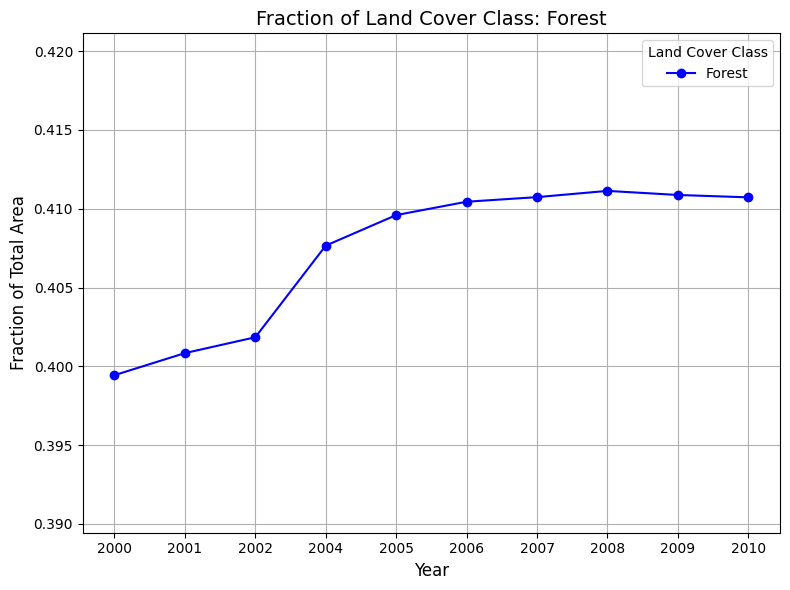

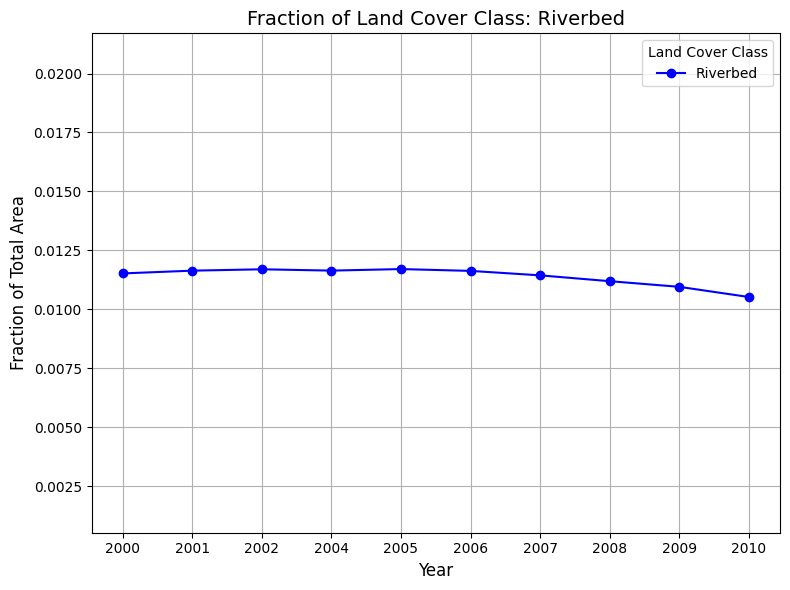

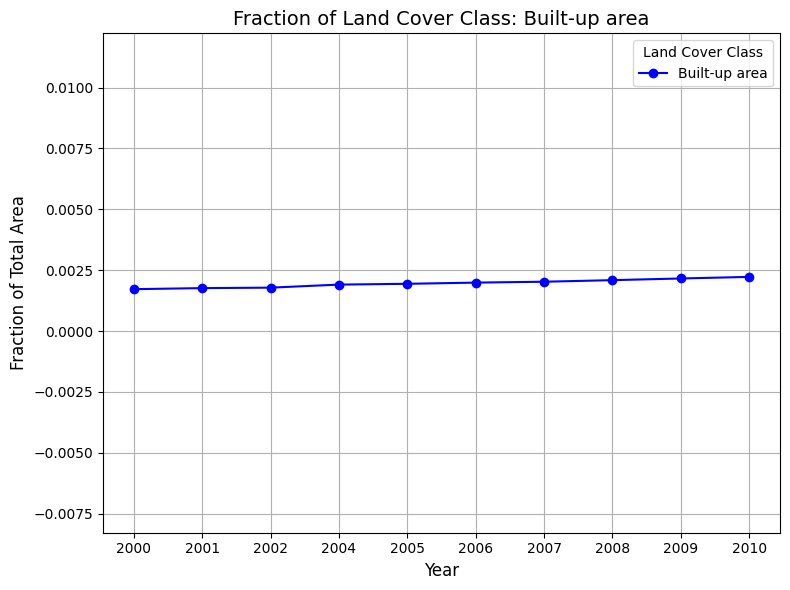

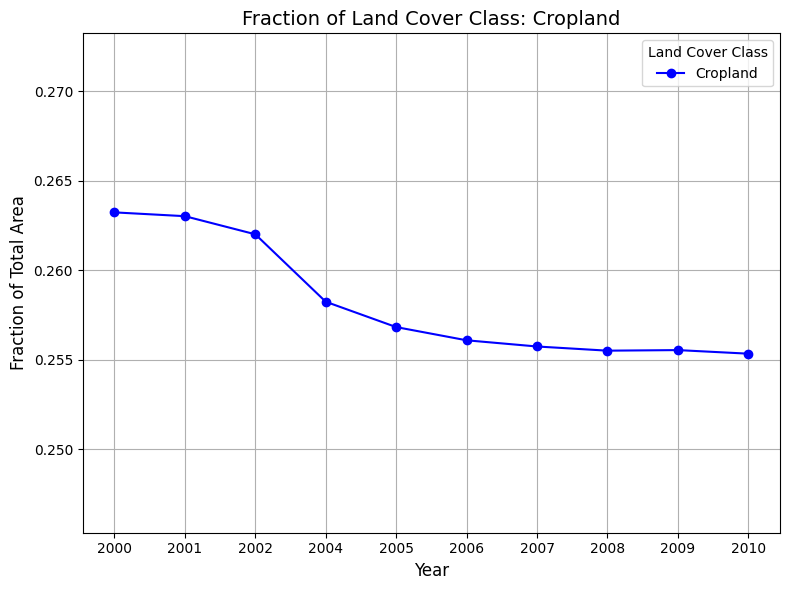

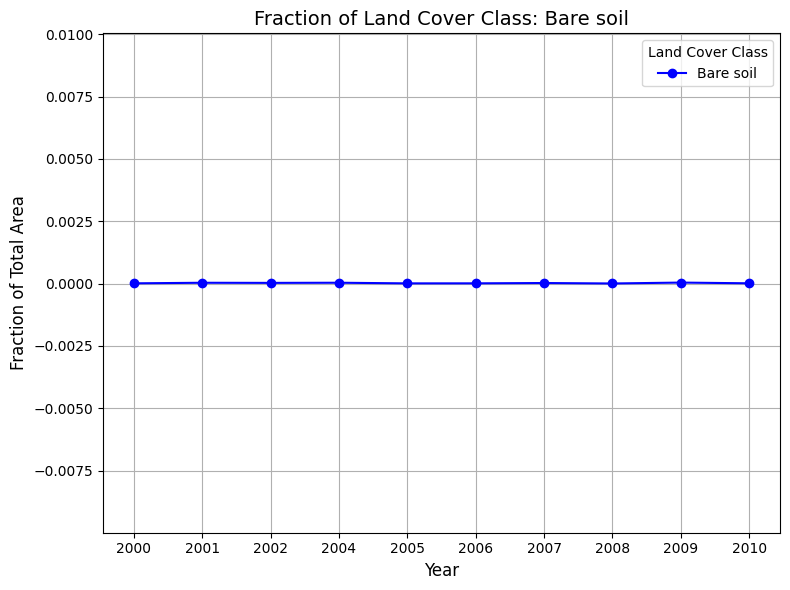

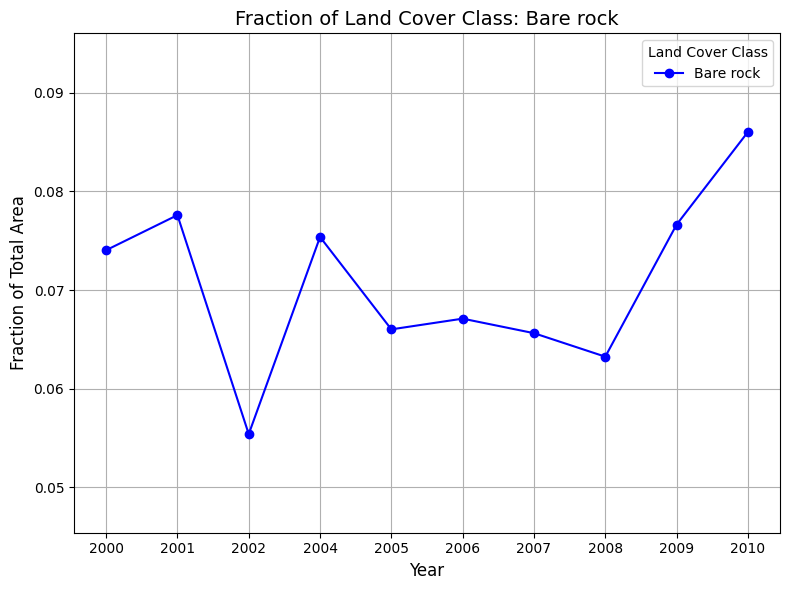

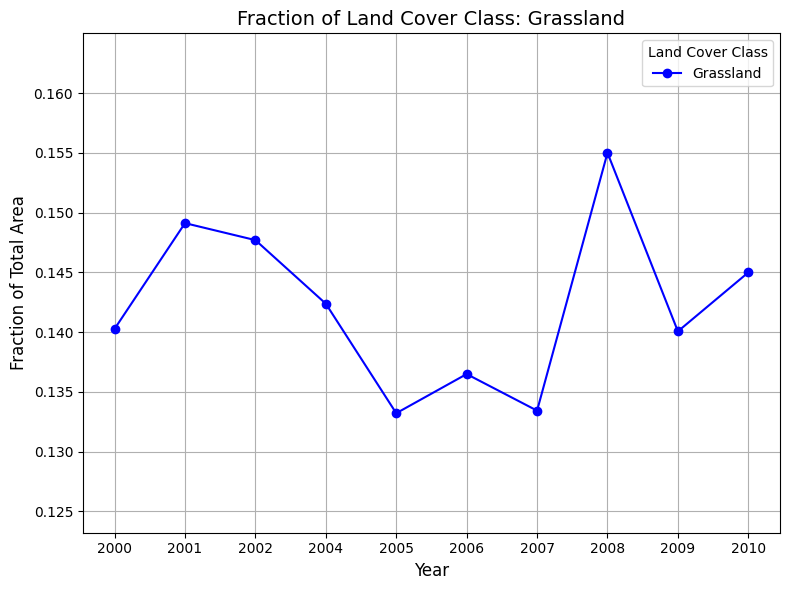

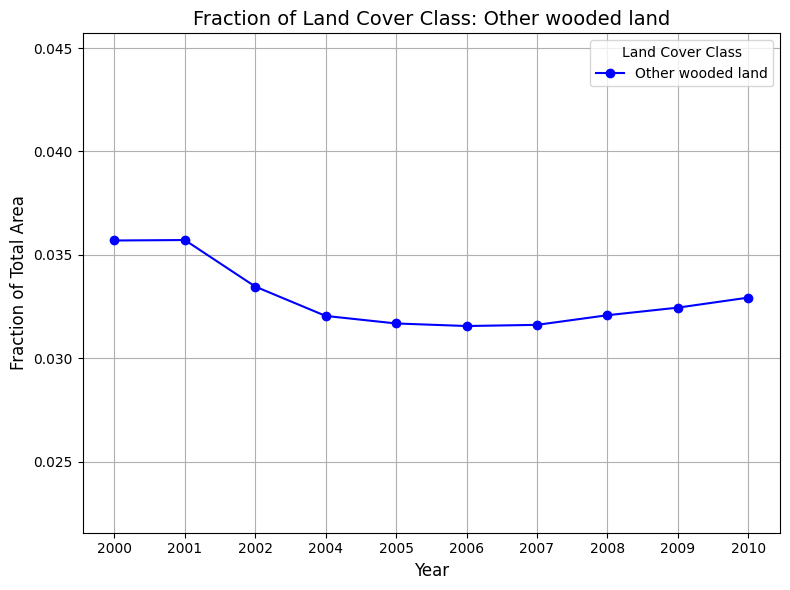

In [68]:
land_cover_classes = np.arange(1, 12)
fractions = {lc_class: [] for lc_class in land_cover_classes}
for year in years:
    data = land_cover_data[year]
    valid = data[data > 0]  # Exclude pixels with value 0 (no data)
    total_pixels = valid.size  # Total number of pixels in the raster
    for lc_class in land_cover_classes:
        class_pixel_count = np.sum(data == lc_class)
        fraction = class_pixel_count / total_pixels  # Calculate fraction
        fractions[lc_class].append(fraction)

# Step 3: Plot individual graphs for each land cover class
for lc_class in land_cover_classes:
    plt.figure(figsize=(8, 6))

    # Get fraction values for the class
    fractions_class = fractions[lc_class]
    max_fraction = max(fractions_class)
    min_fraction = min(fractions_class)

    # Plot the graph
    plt.plot(years, fractions_class, marker='o', linestyle='-', color='b')
    class_name = land_cover_names.get(lc_class, f"Class {lc_class}")  # Use name if available
    plt.title(f"Fraction of Land Cover Class: {class_name}", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Fraction of Total Area", fontsize=12)
    plt.ylim(min_fraction - 0.01, max_fraction + 0.01)  # Dynamic range
    plt.grid(True)
    plt.legend([class_name], title="Land Cover Class")
    plt.tight_layout()
    plt.show()